In [1]:
import autograd.numpy as np
from autograd import grad, elementwise_grad
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
sns.set_style('whitegrid')

# Harmonic Oscillator

$$q=A\cdot cos\left(\sqrt{\frac{k}{m}}t+\varphi\right), \hspace{0.5 cm} E=\frac{m}{2}\dot{q}^2+\frac{k}{2}kq^2$$
let $m=1$, $k=1$:
$$q=Acos\left(t\right), \hspace{0.5 cm} 2E=\dot{q}^2+q^2$$
$$p=m\dot q=\dot q$$
$$2E=p^2+q^2$$
which looks like an equation of a circle with radius: $r=\sqrt{2E}$.<br>
Different energies describe unique circles in phase space $(q, p)$<br>
We should parameterize initial $q$ and $p$, so that: 
$$q=\sqrt{2E}cos(t) \hspace{0.5 cm} p=\sqrt{2E}sin(t)$$
satisfies equation for $E$.

In [2]:
# time
T = np.sort(np.random.uniform(0, 20, 30))
# energies
energies = np.random.uniform(0.2, 1, 50)

In [3]:
def hamiltonian(qp):
    q = qp[0]
    p = qp[1]
    return 0.5 * p**2 + 0.5 * q**2

In [4]:
def symplectic(t, qp):
    nabla_h = grad(hamiltonian)(qp)
    dhdq = nabla_h[0]
    dhdp = nabla_h[1]
    return [dhdp, -dhdq]    

In [5]:
q = []
p = []

q_dot = []
p_dot = []

for E in energies:
    t = np.random.uniform(0, 2)
    q_init = np.sqrt(2 * E) * np.cos(t)
    p_init = np.sqrt(2 * E) * np.sin(t)
    y0 = [q_init, p_init]
    
    symplectic_ivp = solve_ivp(fun=symplectic, t_span=[0, 20], y0=y0, t_eval=np.sort(T))
    q.append(symplectic_ivp['y'][0] + np.random.normal(0, 0.1, 30))
    p.append(symplectic_ivp['y'][1] + np.random.normal(0, 0.1, 30))
    
    dots = np.array([np.array(symplectic(None, qp)) for qp in symplectic_ivp['y'].T])
    q_dot.append(dots[:,0])
    p_dot.append(dots[:,1])
        
q = np.array(q)
p = np.array(p)

q_dot = np.array(q_dot)
p_dot = np.array(p_dot)

Text(0.5, 1.0, 'Generated phase space trajectory with added noise')

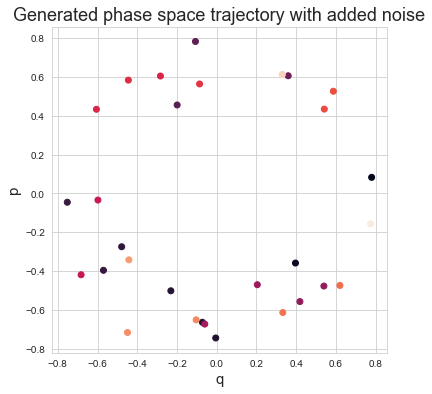

In [6]:
plt.figure(figsize=(6,6))
plt.scatter(q[0], p[0], c=T)
plt.xlabel('q', size=15)
plt.ylabel('p', size=15)
plt.title('Generated phase space trajectory with added noise', size=18)

In [7]:
X = np.stack((q, p), axis=-1)

In [8]:
X[0][:10]

array([[ 0.78036772,  0.08299332],
       [ 0.39670174, -0.35766946],
       [-0.00487405, -0.74297216],
       [-0.07218   , -0.66229701],
       [-0.23087639, -0.50039583],
       [-0.47863183, -0.2739035 ],
       [-0.57028851, -0.39500061],
       [-0.75245318, -0.04508674],
       [-0.19921173,  0.45507162],
       [-0.10702406,  0.78159228]])

In [9]:
y = np.stack((q_dot, p_dot), axis=-1)

# Models

In [10]:
# baseline nn
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        
        self.l1 = nn.Linear(2, 200)
        self.l1 = nn.Linear(200, 200)
        self.l1 = nn.Linear(200, 2)
        
    def forward(self, x):
        x = nn.Tanh(self.l1(x))
        x = nn.Tanh(self.l2(x))
        out = nn.Tanh(self.l3(x))
        
        return out